<div class="row">
    <div class="column">
        <img src="https://datasciencecampus.ons.gov.uk/wp-content/uploads/sites/10/2017/03/data-science-campus-logo-new.svg"
             alt="Data Science Campus Logo"
             align="right" 
             width = "340"
             style="margin: 0px 60px"
             />
    </div>
    <div class="column">
        <img src="https://cdn.ons.gov.uk/assets/images/ons-logo/v2/ons-logo.svg"
             alt="ONS Logo"
             align="left" 
             width = "420"
             style="margin: 0px 30px"/>
    </div>
</div>

# Falling Bombs on London

During World War 2, when V-1 rocket bombs were falling on London, the War Office asked an actuary to find out whether the V-1s were falling at random. The fear was that the Nazis might be capable of targetting the V-1 rockets, making much of the UK's critical infastructure vulnerable to attack.

Determining whether or not the V-1 bombs were falling at random, or according to some predetermined spatial pattern, required the actuary tasked with the analysis, R. D. Clarke, to use probability, and the Poisson distribution.

This practical exercise is based on an article published by former Data Science Campus Faststream statistician Luke Shaw and his brother Liam. To see the article, which is open access, click [here](https://rss.onlinelibrary.wiley.com/doi/full/10.1111/j.1740-9713.2019.01315.x?af=R).

This analysis uses python, and attempt to visualise the analytical process by taking an expressly spatial approach. To see Luke's R workflow, go [here](https://lukefshaw.netlify.com/the-flying-bomb-and-the-actuary-supplementary-analysis/).

Note, the `geopandas` library is not available as standard through the anaconda distribution, so you will need to install it and its dependencies prior to working through this example.

In [1]:
# Standard imports
import pandas as pd
from zipfile import ZipFile
import matplotlib.pyplot as plt
from scipy.stats import poisson, binom, chisquare
import random
import numpy as np

# geospatial imports (having geopandas entails having all of these)
import geopandas as gpd
import fiona
from shapely.geometry import box, Point

# Optional geospatial import
from pysal.lib.cg import alpha_shape_auto

%matplotlib inline

C:\Python36\lib\site-packages\pysal\explore\segregation\network\network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
C:\Python36\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


# Data Preparation

The data were downloaded as .kmz files, a file type used by Google for storing spatial data. As you can see, this is a little tricky to work with - first we have to tell `fiona`, python's spatial data io library, that it can work with kml, and second, we have to unzip the kmz files, which are standard zip files with a different file extension.

In [2]:
# Adds kml to the supported drivers dictionary
fiona.drvsupport.supported_drivers['kml'] = 'rw'
fiona.drvsupport.supported_drivers['KML'] = 'rw'

In [3]:
# Extract KMZ (just a zip file)
bombs = []
for kmz in ['V1.kmz','V2.kmz']:
    with ZipFile(kmz, 'r') as zf:
        bombs.append(gpd.read_file(zf.open('doc.kml')).to_crs({'init':'epsg:27700'}))

bombs = gpd.pd.concat(bombs).reset_index(drop=True)
    
# Derive Type column
bombs['Type'] = bombs['Name'].str.split('.', expand=True)[0]

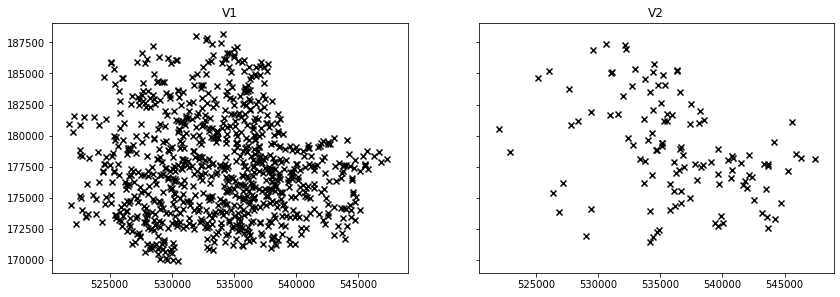

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (14,5), sharex= True, sharey = True)

bombs[bombs['Type'] == 'V1'].plot(color ='k', marker = 'x', ax=ax1)
bombs[bombs['Type'] == 'V2'].plot(color ='k', marker = 'x', ax=ax2)

ax1.set_title("V1")
ax2.set_title("V2");

In [5]:
# Create bounding box
bbox = gpd.GeoDataFrame(crs = {'init':'epsg:27700'}, geometry= [box(525000,172000,543000,180000)])

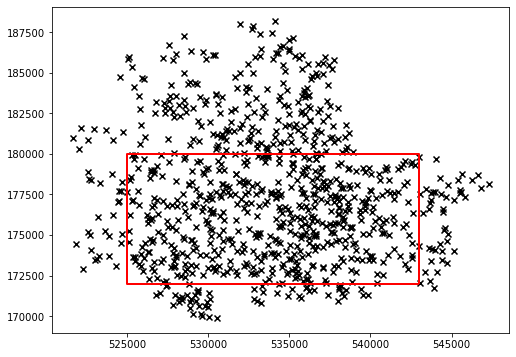

In [6]:
f, ax = plt.subplots(figsize = (10,6))
bombs[bombs['Type'] == 'V1'].plot(color ='k', marker = 'x', ax=ax)
bbox.plot(facecolor = 'none', edgecolor = 'r', linewidth = 2, ax=ax);

In [7]:
# Clarke had 537 bombs

# Points in polygon - 532. Shaw Method.
bombs[(bombs['Type'] == 'V1') & bombs.intersects(bbox['geometry'][0])].shape[0]

532

In [8]:
# Create a grid for bomb counting.
def grid(xmin, ymin, xmax, ymax, xcellsize, ycellsize, crs = None, uid = True):
    """Create a grid of polygons for a given extent, with a given cellsize in x and y"""
    num_cols = int((xmax - xmin + 1) // xcellsize)
    num_rows = int((ymax - ymin + 1) // ycellsize)
    geom = []
    for i in range(num_cols):
        for j in range(num_rows):
            b = box(xmin + (i*xcellsize), ymin + (j*ycellsize), xmin + ((i+1)*xcellsize), ymin + ((j+1)*ycellsize))
            geom.append(b)
    return gpd.GeoDataFrame(data = {'uid':pd.Categorical(range(len(geom)))} if uid else None,
                            crs=crs,
                            geometry = geom)

In [9]:
# Use function to create grid
zones = grid(*bbox['geometry'][0].bounds, 500,500, crs={'init':'epsg:27700'})

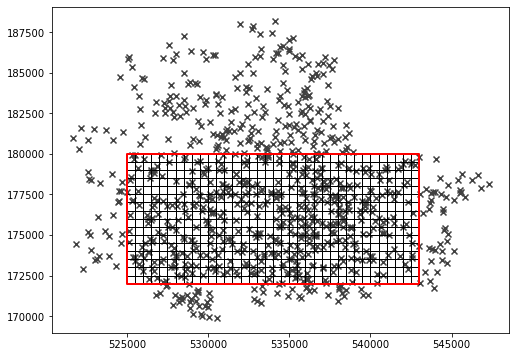

In [10]:
# Visualise the grid
f, ax = plt.subplots(figsize = (10,6))
bombs[bombs['Type'] == 'V1'].plot(color ='0.25', marker = 'x', ax=ax)
zones.plot(facecolor = 'none', edgecolor = 'k', ax=ax)
bbox.plot(facecolor = 'none', edgecolor = 'r', linewidth = 2, ax=ax);

## Observed and Expected Counts

In order to test whether the distribution of bombs is spatially random or not, we can compare the counts we observe with what we would expect given a binomial or poisson process.

To specify a binomial distribution, we have to assess the number of trials $n$ and the probability of success $p$. The number of trials is effectively the number of bombs dropped, while the probability of success is the likelihood that a bomb falling at random hits a given cell in our grid, effectively: $\frac{1}{\mathrm{number\ of\ cells\ in\ grid}}$

A Poisson distribution is described entirely by a single parameter - $\lambda$. Conceptually, lambda is the average intensity of the point pattern of bombs over the study area. This is the number of bombs that fell, divided by the number of cells in our grid.

Now we have a sense of what we need, let's tabulate all the data.

In [14]:
# spatial join for grid onto bombs
observed_counts = (gpd.sjoin(bombs[bombs['Type'] == 'V1'], zones, how = 'inner', op = 'within')['uid']
                   .value_counts() # aggregate by zone id
                   .value_counts() # aggregate by frequencies
                   .rename('Observed Count')
                  )

observed_props = (observed_counts/observed_counts.sum()).rename('Observed Proportion')

The Poisson $\lambda$ is 0.92, effectively suggesting that on average 0.92 bombs falls into each grid cell in our study area.

In [17]:
# Mean bombs by area (Poisson Lambda)
poisson_lambda = (bombs[(bombs['Type'] == 'V1') & bombs.intersects(bbox['geometry'][0])].shape[0]) / len(zones)
poisson_lambda

0.9236111111111112

In [15]:
# Probabilities and Expected counts using Binomial model.
binomial_predictions = [binom(532, 1/576).pmf(k) for k in range(5)]
binomial_predictions += [1-sum(binomial_predictions)] # last value has to be the remaining probability

binomial_predictions = pd.Series(binomial_predictions, name = 'Binomial Probability')

binomial_counts = (binomial_predictions * 576).rename('Binomial Counts')

In [18]:
# Probabilities and Expected counts using Poisson model.
poisson_predictions = [poisson(poisson_lambda).pmf(k) for k in range(5)]
poisson_predictions += [1-sum(poisson_predictions)] # last value has to be the remaining probability

poisson_predictions = pd.Series(poisson_predictions, name = 'Poisson Probability')

poisson_counts = (poisson_predictions * 576).rename('Poisson Counts')

In [19]:
results = (pd.concat([observed_props, observed_counts, binomial_predictions, 
                     binomial_counts, poisson_predictions, poisson_counts], 
                    axis=1)
           .fillna(0))
results

,Observed Proportion,Observed Count,Binomial Probability,Binomial Counts,Poisson Probability,Poisson Counts
0,0.402778,232.0,0.396764,228.536029,0.397083,228.719543
1,0.350694,202.0,0.367093,211.445509,0.366750,211.247911
2,0.182292,105.0,0.169501,97.632665,0.169367,97.555459
3,0.048611,28.0,0.052079,29.997283,0.052143,30.034435
4,0.015625,9.0,0.011978,6.899375,0.012040,6.935035
5,0.000000,0.0,0.002585,1.489139,0.002617,1.507617


The row index indicates grid cells with 0 bomb hits, 1 bomb hit, 2 bombs hits up to 5 bomb hits.

The observed counts are the number of cells in the grid in which we observe 0, 1, 2, 3 ... 5 bomb hits. So in our grid 232 cells are not hit by bombs, while nine cells are hit by four bombs in total. The proportions are out of the total number of cells in our grid.

The binomial probabilities are the probability of observing $k$ bombs, given 532 trials (bombs dropped), and a probability of success (a bomb falling in a given grid cell of 1/576 (i.e. 1 over the number of grid cells)).

The poisson probabilities are the equivalent poisson probabilities given a $\lambda$ of 0.92 bombs per cell on average.

Counts can be created by multiplying binomial and poisson probablities by the number of cells.

We can then compare the observed counts with the expected counts under a binomial or poisson model (these essentially amount to the same thing) using a hypothesis test.

Here we use the $\chi^{2}$ test, which allows us to compared an observed frequency distribution with an expected one.

The hypotheses we're testing are:

$\mathrm{H}_0$: The point pattern observed is spatially random (there is no difference between observed and expected frequency distributions).  
$\mathrm{H}_1$: The point pattern observed deviates from a spatially random pattern (there is a difference between observed and expected frequency distributions)

In [20]:
binom_chi = chisquare(results['Observed Count'], results['Binomial Counts'])
binom_chi.statistic, binom_chi.pvalue

(3.2920740627807312, 0.6550553564287186)

In [21]:
pois_chi = chisquare(results['Observed Count'], results['Poisson Counts'])
pois_chi.statistic, pois_chi.pvalue

(3.2802848197078163, 0.6568613928375122)

The chi-squared statistics does not exceed the critical value and the p-value computed - 0.65 - suggests that we should accept the null hypothesis ($\mathrm{H}_{0}$) that the pattern of bombs is spatially random.

# Simulation Approach

This is a similar approach to the simulation that Luke and Liam implement.

In [23]:
xys = np.row_stack(bombs[bombs['Type'] == 'V1']['geometry'].apply(lambda coord: [coord.x,coord.y]))

In [24]:
alpha_hull = gpd.GeoDataFrame(crs = {'init':'epsg:27700'}, geometry = [alpha_shape_auto(xys)])

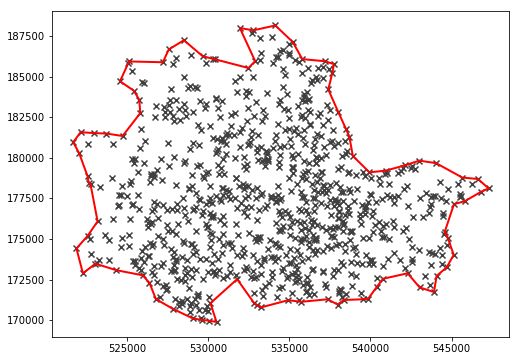

In [25]:
# Visualise the boundary
f, ax = plt.subplots(figsize = (10,6))
bombs[bombs['Type'] == 'V1'].plot(color ='0.25', marker = 'x', ax=ax)
alpha_hull.plot(facecolor = 'none', edgecolor = 'r', linewidth = 2, ax=ax);

In [26]:
# generate a random point within a polygon, with buffer.
def generate_n_random_points_in_polygon(n, poly, radius):
    return [generate_random_point_in_polygon(poly, radius) for _ in range(n)]

def generate_random_point_in_polygon(poly, radius):
    minx, miny, maxx, maxy = poly.bounds
    while True:
        p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if poly.contains(p.buffer(radius)):
            return p

In [27]:
# Get a sample of points within the boundary.
num_points = 1000
radius = np.sqrt(250000/np.pi) # to get a circle of radius 0.25km2

sample = gpd.GeoDataFrame(crs = {'init':'epsg:27700'},
                          geometry = generate_n_random_points_in_polygon(num_points, alpha_hull['geometry'][0], radius))

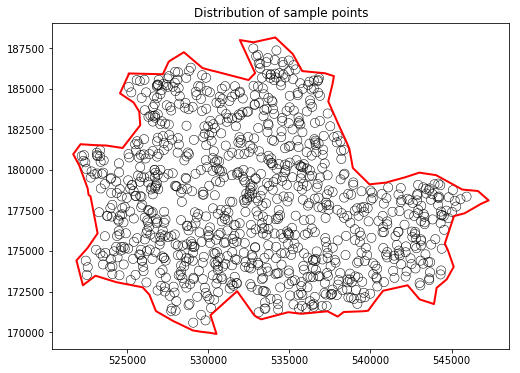

In [30]:
# Visualise the sample
f, ax = plt.subplots(figsize = (10,6))
sample.buffer(282).plot(facecolor = 'none', edgecolor = 'k', linewidth = 0.5, ax=ax)
alpha_hull.plot(facecolor = 'none', edgecolor = 'r', linewidth = 2, ax=ax)
ax.set_title("Distribution of sample points");

In [31]:
# count all bombs within a circle of given radius for each sample
def count_bombs(sample_point, radius, bombs):
    return bombs['geometry'].intersects(sample_point.buffer(radius)).sum()

In [32]:
# count bombs
sample['bomb count'] = sample['geometry'].apply(lambda x: count_bombs(x, radius, bombs[bombs['Type'] == 'V1']))

In [33]:
# Get observed bomb counts based on simulation
observed_count = (sample['bomb count']
                  .value_counts()
                  .sort_index()
                  .rename('Observed Count')
                  )

observed_prop = (observed_count/observed_count.sum()).rename('Observed Proportion')

In [34]:
# Get lambda for simulation
poisson_lambda = sample['bomb count'].sum() / len(sample)

In [35]:
# Probabilities and Expected counts using Binomial model.
binomial_predictions = [binom(sample['bomb count'].sum(), 1/num_points).pmf(k) for k in range(5)]
binomial_predictions += [1-sum(binomial_predictions)]
binomial_predictions = pd.Series(binomial_predictions, name = 'Binomial Probability')
binomial_counts = (binomial_predictions * num_points).rename('Binomial Counts')

In [36]:
# Probabilities and Expected counts using Poisson model.
poisson_predictions = [poisson(poisson_lambda).pmf(k) for k in range(5)]
poisson_predictions += [1-sum(poisson_predictions)]
poisson_predictions = pd.Series(poisson_predictions, name = 'Poisson Probability')
poisson_counts = (poisson_predictions * num_points).rename('Poisson Counts')

In [37]:
results = (pd.concat([observed_prop, observed_count, binomial_predictions, binomial_counts, 
                      poisson_predictions, poisson_counts], 
                    axis=1)
           .fillna(0))
results

,Observed Proportion,Observed Count,Binomial Probability,Binomial Counts,Poisson Probability,Poisson Counts
0,0.471,471,0.456397,456.396988,0.456576,456.576050
1,0.340,340,0.358173,358.173412,0.357956,357.955623
2,0.139,139,0.140365,140.365256,0.140319,140.318604
3,0.037,37,0.036625,36.625169,0.036670,36.669929
4,0.010,10,0.007158,7.158222,0.007187,7.187306
5,0.003,3,0.001281,1.280954,0.001292,1.292489


In [38]:
binom_chi = chisquare(results['Observed Count'], results['Binomial Counts'])
binom_chi.statistic, binom_chi.pvalue

(4.841599359440248, 0.435516066720129)

In [39]:
pois_chi = chisquare(results['Observed Count'], results['Poisson Counts'])
pois_chi.statistic, pois_chi.pvalue

(4.728243879238833, 0.4499373497521483)